In [106]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

import re
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import regexp_tokenize, RegexpTokenizer, word_tokenize

from keras import initializers, regularizers, optimizers, layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, Input, Dense, LSTM, Embedding, Flatten, BatchNormalization
from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras.regularizers import l2
from keras.utils import pad_sequences


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer




# QOL libraries
import os
import seaborn as sns
import random


random.seed(13)

<h1>RNN Disaster Tweets</h1>
  
  
#### Table of Contents

- [Problem and Data Description](#a)
- [EDA and Data Preprocessing](#b)
- [Model Architecture](#c)
- [Results and Analysis](#d)
- [Conclusion](#e)
- [References](#f)

<h2>Problem and Data Description</h2><a name="a"></a>

This notebook is a submission for the Kaggle competition <a href = "https://www.kaggle.com/c/nlp-getting-started/overview">Natural Language Processing with Disaster Tweets</a>.  The premise of this competition is to create a model that will utilize Natural Language Processing to take tweets as inputs and determines whether or not they are about real disasters.

The data consists of two parts, and the first is a large folder of histopathologic scans of lymph nodes.  Each image has their respective image ID as their name, and is saved in a .tif format.  The images are also perfectly squared with dimensions of 96 pixels in width, 96 pixels in height, and has a depth of 3.  The folder is further split into a set of images for training our models, as well as another set for testing used to create the competition submission.

The data consists of primarily one main dataset, with five columns.  The columns are:

- id - an unique identifier integer for each individual tweet
- keyword - a string helping to describe the tweet
- location - a string describing the location of the tweet
- text - a string consisting of the text in the tweet
- target - a binary integer describing whether or not the tweet is about a disaster, with a value of 1 being yes and a value of 0 being no

Our training dataset comes with 7,613 unique tweets for us to fit our model with.

In [91]:
path = 'data/'

df = pd.read_csv(path + 'train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [64]:
df.shape

(7613, 6)

<h2>Exploratory Data Analysis and Data Preprocessing</h2><a name="b"></a>

First we can explore a bit on how each columns' contents look like.

In [79]:
df['text'].sample(5)

3002    || So.... I just watched the trailed for The D...
3242    Men escape car engulfed in flames in Parley's ...
4748         The Lightning out here is something serious!
2851    For those displaced by disasters label and leg...
259     U.S National Park Services Tonto National Fore...
Name: text, dtype: object

In [80]:
df['keyword'].sample(5)

7324    wild%20fires
7412         wounded
3603           fatal
2777     devastation
4552         injured
Name: keyword, dtype: object

In [81]:
df['location'].sample(5)

3849         houstn
949          Gotham
5215            NaN
6402       Helsinki
5750    Detroit, MI
Name: location, dtype: object

Now we can do the usual checks of duplications and NA values.  While there are no duplicate rows, we can see that NA values will be an issue.  While 'keyword' has a low amount of NA values that can be worked around, 'location' has 1/3 of its values missing.  In this scenario, we will drop any row that has an NA value in 'keyword' while dropping the 'location' column entirely.

In [82]:
df[df.duplicated()]

,id,keyword,location,text,target


In [83]:
df.isna().sum()/ len(df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [93]:
df_cln = df.drop(columns = ['location'])
df_cln = df_cln.dropna(subset = ['keyword'])

df_cln.isna().sum()/ len(df_cln)

id         0.0
keyword    0.0
text       0.0
target     0.0
dtype: float64

Now we can check for signs of class imbalance.  There does not appear to be a large imbalance so we can safely proceed.

In [96]:
df_cln['target'].value_counts()

0    4323
1    3229
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

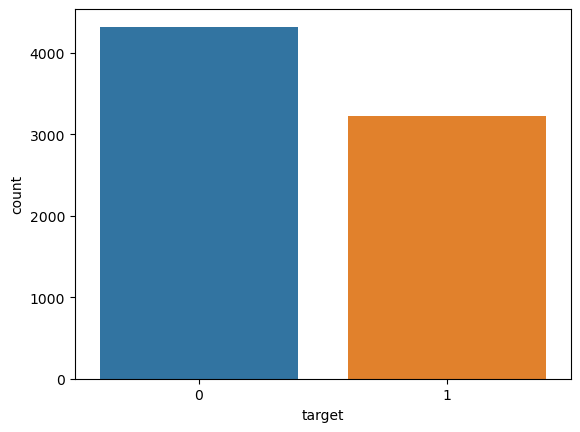

In [108]:
sns.countplot(x = 'target', data = df_cln)

As we are going to use NLP techniques, we must prepare the text data in a way to best suit it.  We will do the following to help clean the text:

1. Splitting the text up into words
2. Turning the words lowercase
3. Removing punctuation
4. Removing @'s which are twitter jargon
5. Removing leftover numbers
6. Removing words with accents
7. Removing stop words and more twitter jargon
8. Change targets in string to 'product_target' if a target exists
9. Removing empty strings
10. Joining all the strings together into one

We will clean both the 'text' column and the 'keyword' column, then combine the two.

In [105]:
def clean(txt):
    sw = stopwords.words('english')
    sw.extend(['link', 'rt', 'get'])
    punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!#'
    no_accents_re = re.compile('^[a-z]+$')
    accents = ['á', 'â', 'ã', 'à', 'å', 'ª', 'ç', 'è', '¼', '¾', 'î', 'ï', 'ì', 'ó', 'ö', 'ð', 'ü', 'ù', 'û', 'ý']
    twitter_re = re.compile('[@][a-zA-Z]*')
    num_re = re.compile('^\d+$')
    
    if isinstance(txt, list):
        t = txt[0].split(' ')
    else:
        t = txt.split(' ')
    t = [w.lower() for w in t]
    t = [w.translate(w.maketrans('','', punctuation)) for w in t]
    t = [w for w in t if not twitter_re.match(w)]
    t = [w for w in t if not num_re.match(w)]
    t = [w for w in t if no_accents_re.match(w)]
    t = [w for w in t if w not in sw]
    if isinstance(txt, list):
        t = ['product_target' if w in product_target(txt[1]) else w for w in t]
        if txt[1].lower() in ['android app', 'ipad or iphone app']:
            t = [w for w in t if w != 'app']
    t = [w for w in t if w]

    return ' '.join(t)

df_cln['txt_cln'] = df_cln['text'].apply(clean)
df_cln['keyword_cln'] = df_cln['keyword'].apply(clean)
df_cln['txt_f'] = df_cln['txt_cln'] + ' ' + df_cln['keyword_cln']

After the text is cleaned, we can check the contents of the two different types of tweets.  

First we check the typical word count between the two types of tweets.  While there is some class imbalance, we can tell that both have a normal distribution with tweets relating to a disaster having a higher average number of words.

<AxesSubplot:xlabel='txt_f', ylabel='count'>

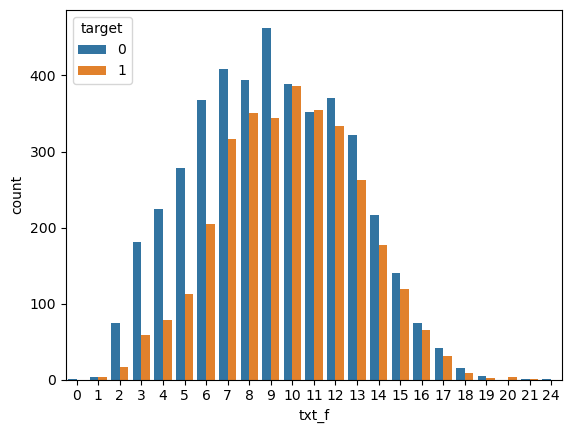

In [176]:
sns.countplot(x = df_cln['txt_f'].str.split().apply(len), hue = df_cln['target'])

Then we can check the most popular words between the two types of tweets.  In normal, non-disaster related tweets, the top ten common words are all typical everyday words.  However in disaster related tweets, the top ten common words all have serious connotations such as "fire" or "suicide".

In [166]:
df_0 = pd.DataFrame(' '.join(df_cln[df_cln['target'] == 0]['txt_cln'].values).split(), columns = ['words'])
df_1 = pd.DataFrame(' '.join(df_cln[df_cln['target'] == 1]['txt_cln'].values).split(), columns = ['words'])

<AxesSubplot:xlabel='count', ylabel='words'>

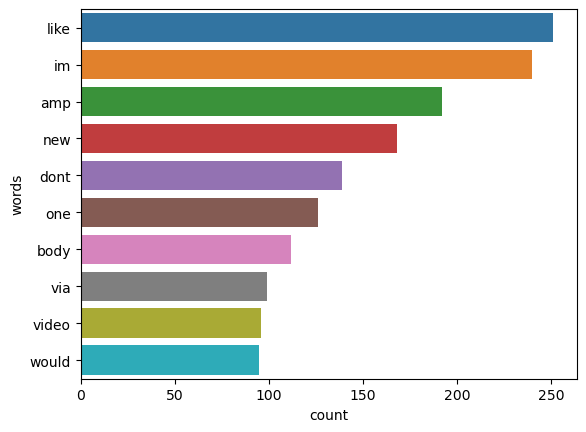

In [171]:
sns.countplot(y = 'words', data = df_0, order = df_0['words'].value_counts().iloc[:10].index)

<AxesSubplot:xlabel='count', ylabel='words'>

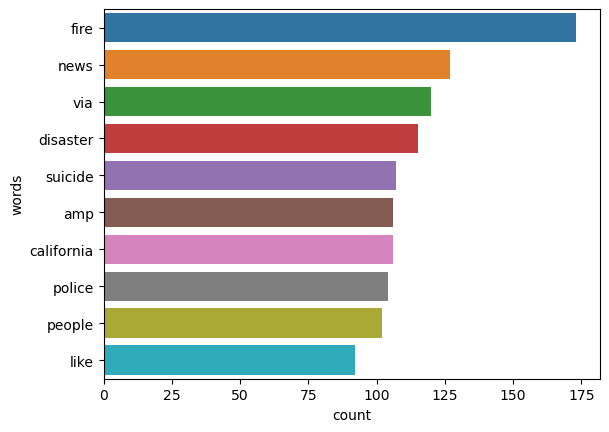

In [170]:
sns.countplot(y = 'words', data = df_1, order = df_1['words'].value_counts().iloc[:10].index)

The last data preprocessing step will be to tokenize our text.  This turns our text data into something that makes more sense for the machine model to read.  While we are at it, we will also split our data into a training set and a validation set.

In [180]:
tokenizer = text.Tokenizer(num_words = 3000, split = ' ')
tokenizer.fit_on_texts(list(df_cln['txt_cln'].values))
X = pad_sequences(tokenizer.texts_to_sequences(df_cln['txt_f'].values))
y = df_cln['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

X_train

array([[   0,    0,    0, ...,  733,   22, 1565],
       [   0,    0,    0, ...,    0,  516,  516],
       [   0,    0,    0, ...,    3,  192,  495],
       ...,
       [   0,    0,    0, ..., 2131, 1498,  717],
       [   0,    0,    0, ...,  229,  282, 2352],
       [   0,    0,    0, ...,  111,  430,   77]])

<h2>Model Architecture</h2><a name="c"></a>

As we are undergoing Natural Language Processing tasks in this scenario, the best model architecture for us to use will be Recurrent Neural Networks.  This is due to NLP tasks works with not just the individual words but how they fit together as a whole, thus maintaining the context of each text sentence is something that we cannot ignore.  RNNs work well in this situation as they are used for handling sequential data, which means it keeps track of the order of individual words as it progresses.  RNN is also able to utilize the word embedding we did earlier with the tokenizer which will greatly speed up the learning process.  In addition, we will utilize Long Short Term Memory networks, which is a modified version of RNNs that put more of an emphasis on keeping track of past data, as well as resolves the issue of vanishing gradients for RNNs.

To begin, we start with a basic LSTM model with mostly default hyperparameters.  Just by itself we can see the efficiency of LSTMs as we begin with a solid validation accuracy of around 0.78 ~ 0.80.  With this as a starting point, we can now undergo a series of hyperparameter tuning to see if we can improve the score.

In [181]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64

model = Sequential()

model.add(Embedding(dictionary_length, sequence_len))
model.add(LSTM(50))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 32, 
                    validation_data = (X_test, y_test))

Epoch 1/5
189/189 [==============================] - 4s 14ms/step - loss: 0.5514 - accuracy: 0.7115 - val_loss: 0.4268 - val_accuracy: 0.8140
Epoch 2/5
189/189 [==============================] - 2s 13ms/step - loss: 0.3712 - accuracy: 0.8356 - val_loss: 0.4358 - val_accuracy: 0.8041
Epoch 3/5
189/189 [==============================] - 2s 13ms/step - loss: 0.3154 - accuracy: 0.8641 - val_loss: 0.4686 - val_accuracy: 0.8001
Epoch 4/5
189/189 [==============================] - 2s 13ms/step - loss: 0.2721 - accuracy: 0.8840 - val_loss: 0.5264 - val_accuracy: 0.7876
Epoch 5/5
189/189 [==============================] - 2s 13ms/step - loss: 0.2359 - accuracy: 0.9048 - val_loss: 0.6143 - val_accuracy: 0.7869


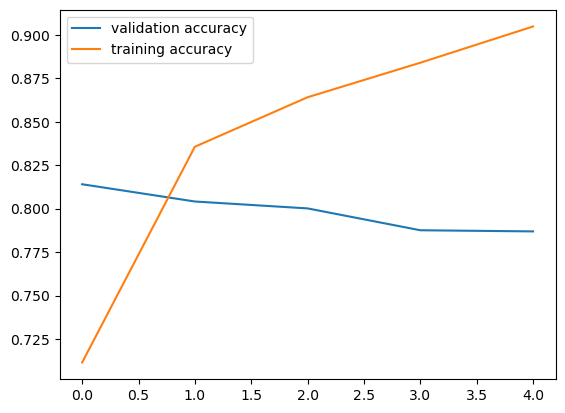

In [183]:
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

Increasing the LSTM input value to 500:

In [184]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64

model_1 = Sequential()

model_1.add(Embedding(dictionary_length, sequence_len))
model_1.add(LSTM(500))
model_1.add(Dense(1, activation = 'sigmoid'))

model_1.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_1 = model_1.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 32, 
                    validation_data = (X_test, y_test))

Epoch 1/5
189/189 [==============================] - 21s 105ms/step - loss: 0.5609 - accuracy: 0.7073 - val_loss: 0.4592 - val_accuracy: 0.8008
Epoch 2/5
189/189 [==============================] - 20s 105ms/step - loss: 0.3810 - accuracy: 0.8371 - val_loss: 0.4435 - val_accuracy: 0.8127
Epoch 3/5
189/189 [==============================] - 19s 98ms/step - loss: 0.3199 - accuracy: 0.8644 - val_loss: 0.5221 - val_accuracy: 0.7783
Epoch 4/5
189/189 [==============================] - 19s 99ms/step - loss: 0.2754 - accuracy: 0.8868 - val_loss: 0.4901 - val_accuracy: 0.7909
Epoch 5/5
189/189 [==============================] - 19s 99ms/step - loss: 0.2235 - accuracy: 0.9081 - val_loss: 0.5836 - val_accuracy: 0.7723


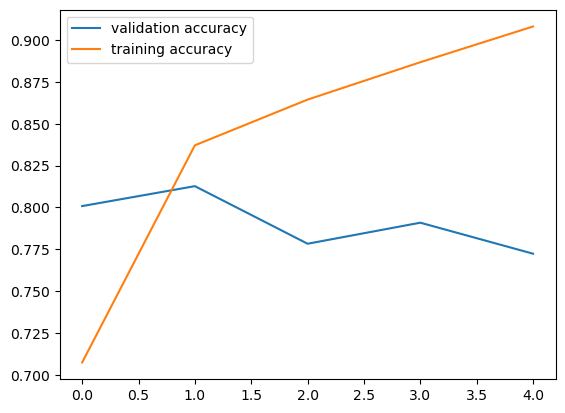

In [185]:
plt.plot(history_1.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history_1.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

Adding dropout layers for regularization:

In [186]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64
dropout = 0.2

model_2 = Sequential()

model_2.add(Embedding(dictionary_length, sequence_len))
model_2.add(Dropout(dropout))
model_2.add(LSTM(50))
model_2.add(Dropout(dropout))
model_2.add(Dense(1, activation = 'sigmoid'))

model_2.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 32, 
                    validation_data = (X_test, y_test))

Epoch 1/5
189/189 [==============================] - 4s 15ms/step - loss: 0.5652 - accuracy: 0.7025 - val_loss: 0.4345 - val_accuracy: 0.8107
Epoch 2/5
189/189 [==============================] - 3s 14ms/step - loss: 0.3842 - accuracy: 0.8336 - val_loss: 0.4373 - val_accuracy: 0.8087
Epoch 3/5
189/189 [==============================] - 3s 15ms/step - loss: 0.3278 - accuracy: 0.8649 - val_loss: 0.4738 - val_accuracy: 0.7942
Epoch 4/5
189/189 [==============================] - 3s 14ms/step - loss: 0.2888 - accuracy: 0.8793 - val_loss: 0.5116 - val_accuracy: 0.7955
Epoch 5/5
189/189 [==============================] - 3s 14ms/step - loss: 0.2516 - accuracy: 0.8944 - val_loss: 0.5799 - val_accuracy: 0.7730


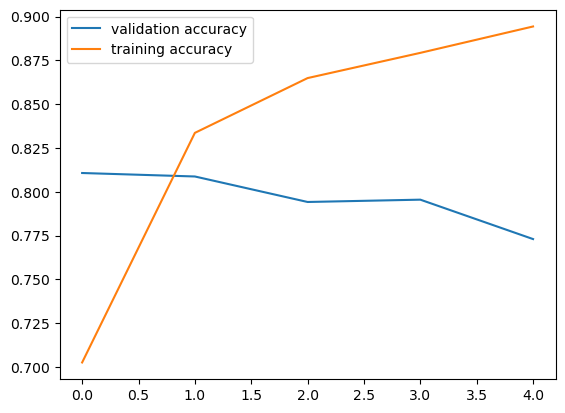

In [187]:
plt.plot(history_2.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history_2.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

Swapping from a sigmoid to a relu activation function:

In [215]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64
dropout = 0.2

model_3 = Sequential()

model_3.add(Embedding(dictionary_length, sequence_len))
model_3.add(Dropout(dropout))
model_3.add(LSTM(50))
model_3.add(Dropout(dropout))
model_3.add(Dense(1, activation = 'relu'))

model_3.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_3 = model_3.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 32, 
                    validation_data = (X_test, y_test))

Epoch 1/5
189/189 [==============================] - 4s 14ms/step - loss: 0.6834 - accuracy: 0.6506 - val_loss: 0.4766 - val_accuracy: 0.7962
Epoch 2/5
189/189 [==============================] - 2s 13ms/step - loss: 0.5048 - accuracy: 0.8002 - val_loss: 0.5089 - val_accuracy: 0.7604
Epoch 3/5
189/189 [==============================] - 2s 13ms/step - loss: 0.4271 - accuracy: 0.8404 - val_loss: 0.6244 - val_accuracy: 0.8074
Epoch 4/5
189/189 [==============================] - 2s 12ms/step - loss: 0.4358 - accuracy: 0.8336 - val_loss: 0.5284 - val_accuracy: 0.7981
Epoch 5/5
189/189 [==============================] - 2s 13ms/step - loss: 0.3791 - accuracy: 0.8666 - val_loss: 0.8022 - val_accuracy: 0.8048


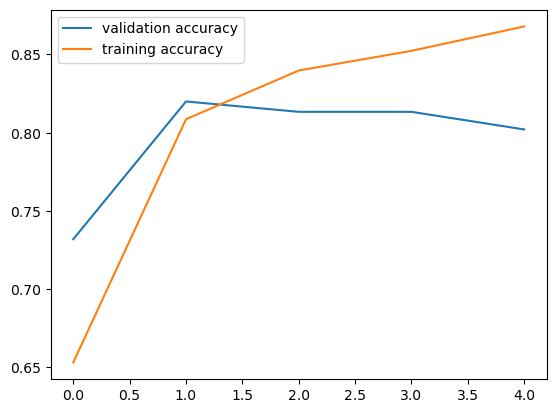

In [189]:
plt.plot(history_3.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history_3.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

Trying a bidirectional LSTM layer:

In [190]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64
dropout = 0.2

model_4 = Sequential()

model_4.add(Embedding(dictionary_length, sequence_len))
model_4.add(Dropout(dropout))
model_4.add(Bidirectional(LSTM(50)))
model_4.add(Dropout(dropout))
model_4.add(Dense(1, activation = 'relu'))

model_4.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_4 = model_4.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 32, 
                    validation_data = (X_test, y_test))

Epoch 1/5
189/189 [==============================] - 5s 18ms/step - loss: 0.6305 - accuracy: 0.6666 - val_loss: 0.5189 - val_accuracy: 0.8140
Epoch 2/5
189/189 [==============================] - 3s 16ms/step - loss: 0.5013 - accuracy: 0.8015 - val_loss: 0.5037 - val_accuracy: 0.8101
Epoch 3/5
189/189 [==============================] - 3s 16ms/step - loss: 0.4186 - accuracy: 0.8424 - val_loss: 0.5999 - val_accuracy: 0.8173
Epoch 4/5
189/189 [==============================] - 3s 16ms/step - loss: 0.4028 - accuracy: 0.8571 - val_loss: 0.6737 - val_accuracy: 0.8068
Epoch 5/5
189/189 [==============================] - 3s 17ms/step - loss: 0.3944 - accuracy: 0.8586 - val_loss: 0.5656 - val_accuracy: 0.8021


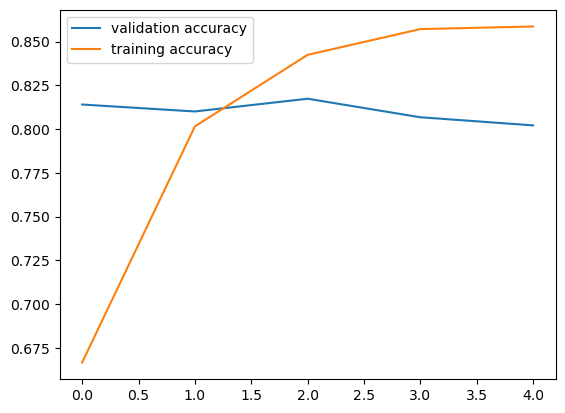

In [191]:
plt.plot(history_4.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history_4.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

Adding more dense layers:

In [193]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64
dropout = 0.2

model_5 = Sequential()

model_5.add(Embedding(dictionary_length, sequence_len))
model_5.add(Dropout(dropout))
model_5.add(LSTM(50))
model_5.add(Dropout(dropout))
model_5.add(Dense(dictionary_length, activation = "relu"))
model_5.add(Dropout(dropout))
model_5.add(Dense(1, activation = 'relu'))

model_5.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_5 = model_5.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 32, 
                    validation_data = (X_test, y_test))

Epoch 1/5
189/189 [==============================] - 5s 22ms/step - loss: 0.5958 - accuracy: 0.7199 - val_loss: 0.4640 - val_accuracy: 0.8101
Epoch 2/5
189/189 [==============================] - 4s 21ms/step - loss: 0.5181 - accuracy: 0.8033 - val_loss: 2.7112 - val_accuracy: 0.6109
Epoch 3/5
189/189 [==============================] - 4s 20ms/step - loss: 0.5113 - accuracy: 0.8020 - val_loss: 0.4671 - val_accuracy: 0.8054
Epoch 4/5
189/189 [==============================] - 4s 21ms/step - loss: 0.4144 - accuracy: 0.8542 - val_loss: 0.6703 - val_accuracy: 0.8061
Epoch 5/5
189/189 [==============================] - 4s 21ms/step - loss: 0.3632 - accuracy: 0.8735 - val_loss: 0.8482 - val_accuracy: 0.7962


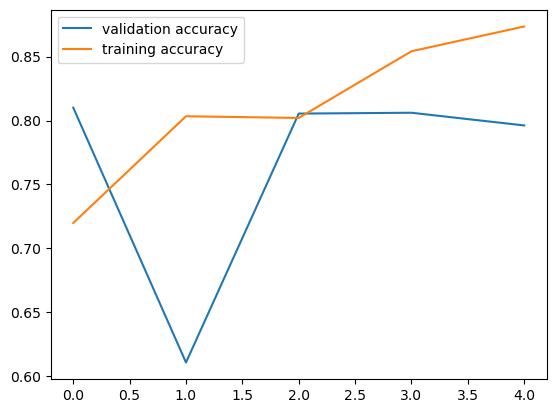

In [194]:
plt.plot(history_5.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history_5.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

Adding multiple LSTM layers:

In [196]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64
dropout = 0.2

model_6 = Sequential()

model_6.add(Embedding(dictionary_length, sequence_len))
model_6.add(Dropout(dropout))
model_6.add(LSTM(50, return_sequences = True))
model_6.add(Dropout(dropout))
model_6.add(LSTM(25))
model_6.add(Dropout(dropout))
model_6.add(Dense(1, activation = 'relu'))

model_6.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_6 = model_6.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 32, 
                    validation_data = (X_test, y_test))

Epoch 1/5
189/189 [==============================] - 6s 18ms/step - loss: 0.6927 - accuracy: 0.6616 - val_loss: 0.5320 - val_accuracy: 0.7895
Epoch 2/5
189/189 [==============================] - 3s 15ms/step - loss: 0.5364 - accuracy: 0.8040 - val_loss: 0.5184 - val_accuracy: 0.8180
Epoch 3/5
189/189 [==============================] - 3s 15ms/step - loss: 0.4469 - accuracy: 0.8411 - val_loss: 0.5716 - val_accuracy: 0.8048
Epoch 4/5
189/189 [==============================] - 3s 15ms/step - loss: 0.4167 - accuracy: 0.8600 - val_loss: 0.8098 - val_accuracy: 0.8107
Epoch 5/5
189/189 [==============================] - 3s 16ms/step - loss: 0.3868 - accuracy: 0.8717 - val_loss: 0.8454 - val_accuracy: 0.8081


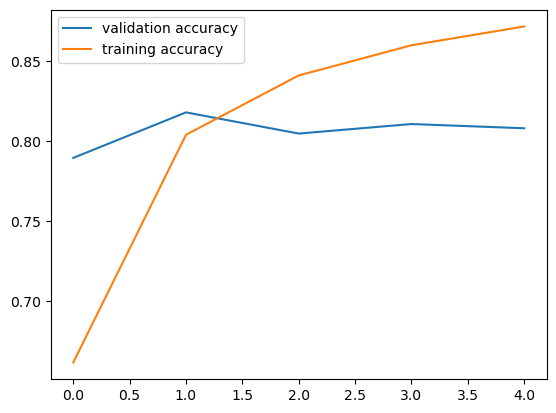

In [197]:
plt.plot(history_6.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history_6.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

Increasing batch size:

In [198]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64
dropout = 0.2

model_7 = Sequential()

model_7.add(Embedding(dictionary_length, sequence_len))
model_7.add(Dropout(dropout))
model_7.add((LSTM(50)))
model_7.add(Dropout(dropout))
model_7.add(Dense(1, activation = 'relu'))

model_7.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_7 = model_7.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 64, 
                    validation_data = (X_test, y_test))

Epoch 1/5
95/95 [==============================] - 3s 18ms/step - loss: 0.7573 - accuracy: 0.5908 - val_loss: 0.5478 - val_accuracy: 0.7465
Epoch 2/5
95/95 [==============================] - 1s 14ms/step - loss: 0.4841 - accuracy: 0.8007 - val_loss: 0.5019 - val_accuracy: 0.7902
Epoch 3/5
95/95 [==============================] - 1s 15ms/step - loss: 0.4548 - accuracy: 0.8234 - val_loss: 0.6152 - val_accuracy: 0.8021
Epoch 4/5
95/95 [==============================] - 1s 15ms/step - loss: 0.3963 - accuracy: 0.8509 - val_loss: 0.6985 - val_accuracy: 0.8107
Epoch 5/5
95/95 [==============================] - 1s 15ms/step - loss: 0.3660 - accuracy: 0.8644 - val_loss: 0.7848 - val_accuracy: 0.8028


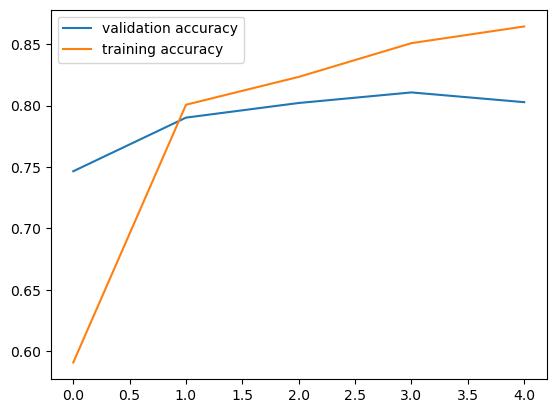

In [199]:
plt.plot(history_7.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history_7.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

Adding regularization to the LSTM layer:

In [200]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64
dropout = 0.2

model_8 = Sequential()

model_8.add(Embedding(dictionary_length, sequence_len))
model_8.add(Dropout(dropout))
model_8.add(LSTM(50, kernel_regularizer = l2(0.001)))
model_8.add(Dropout(dropout))
model_8.add(Dense(1, activation = 'relu'))

model_8.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_8 = model_8.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 64, 
                    validation_data = (X_test, y_test))

Epoch 1/5
95/95 [==============================] - 3s 20ms/step - loss: 0.9027 - accuracy: 0.5691 - val_loss: 0.6689 - val_accuracy: 0.6876
Epoch 2/5
95/95 [==============================] - 2s 17ms/step - loss: 0.5792 - accuracy: 0.7774 - val_loss: 0.6674 - val_accuracy: 0.8081
Epoch 3/5
95/95 [==============================] - 2s 17ms/step - loss: 0.4923 - accuracy: 0.8321 - val_loss: 0.6169 - val_accuracy: 0.8094
Epoch 4/5
95/95 [==============================] - 2s 18ms/step - loss: 0.4283 - accuracy: 0.8479 - val_loss: 0.6917 - val_accuracy: 0.7929
Epoch 5/5
95/95 [==============================] - 2s 18ms/step - loss: 0.3960 - accuracy: 0.8692 - val_loss: 0.8685 - val_accuracy: 0.8074


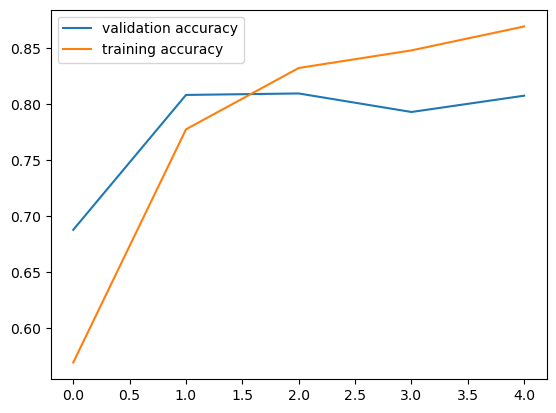

In [201]:
plt.plot(history_8.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history_8.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

Adding early stopping to the fitting function:

In [203]:
dictionary_length = len(tokenizer.word_index.keys()) + 1
sequence_len = 64
dropout = 0.2

model_9 = Sequential()

model_9.add(Embedding(dictionary_length, sequence_len))
model_9.add(Dropout(dropout))
model_9.add(LSTM(50, kernel_regularizer = l2(0.001)))
model_9.add(Dropout(dropout))
model_9.add(Dense(1, activation = 'relu'))

model_9.compile(Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_9 = model_9.fit(X_train, y_train, 
                    epochs = 5, 
                    batch_size = 32, 
                    validation_data = (X_test, y_test),
                    callbacks=[reducel, earlystopper])

Epoch 1/5
189/189 [==============================] - 4s 15ms/step - loss: 0.7266 - accuracy: 0.6686 - val_loss: 0.5650 - val_accuracy: 0.7968 - lr: 0.0010
Epoch 2/5
188/189 [============================>.] - ETA: 0s - loss: 0.5143 - accuracy: 0.7927
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
189/189 [==============================] - 2s 13ms/step - loss: 0.5161 - accuracy: 0.7926 - val_loss: 0.6277 - val_accuracy: 0.8074 - lr: 0.0010
Epoch 3/5
186/189 [============================>.] - ETA: 0s - loss: 0.4131 - accuracy: 0.8490
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch: 1.
189/189 [==============================] - 2s 13ms/step - loss: 0.4139 - accuracy: 0.8492 - val_loss: 0.6578 - val_accuracy: 0.8068 - lr: 1.0000e-04
Epoch 3: early stopping


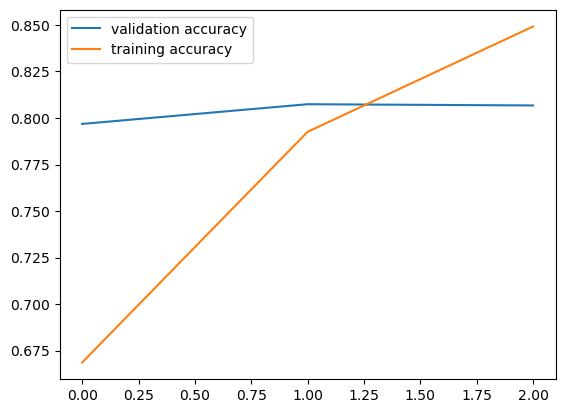

In [204]:
plt.plot(history_9.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history_9.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.show()

<h2>Results and Analysis</h2><a name="d"></a>

By consolidating the best validation accuracies from each model, we can view their results to choose the best one.  While luckily our base model already had a solid performance, none of our other models had a major difference in validation accuracy with at most minimal with less than 0.03 points difference at most.  However our 3rd model did end up having the best, so we will be choosing that as our final model.  

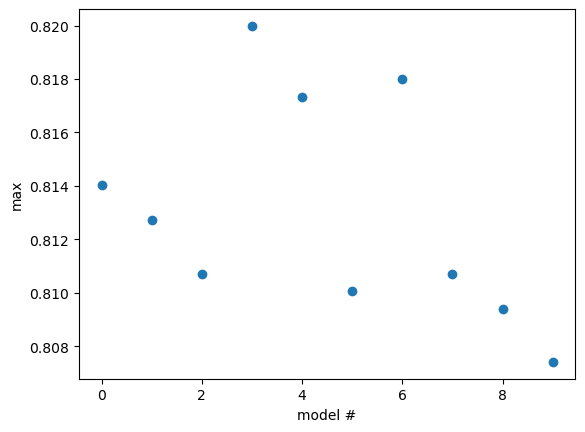

In [212]:
hst = [ history, history_1, history_2, history_3, history_4, history_5, history_6, history_7, history_8, history_9]
hst_val = [ max(i.history['val_accuracy']) for i in hst ]

df_hst = pd.DataFrame({'model': range(0,10), 'val_accuracy': hst_val})

plt.scatter(range(0,10), hst_val)
plt.xlabel('model #')
plt.ylabel('max')
plt.show()

In [218]:
df_hst.sort_values(by=['val_accuracy'], ascending = False)

,model,val_accuracy
3,3,0.819987
6,6,0.818001
4,4,0.817340
0,0,0.814030
1,1,0.812707
2,2,0.810721
7,7,0.810721
5,5,0.810060
8,8,0.809398
9,9,0.807412


The 3rd model had the main hyperparameter changes of having dropout layers to improve regularization and swapping the sigmoid activation function to a relu activation function.  While the dropout layers improving the validation accuracy through adding regularization makes sense, the activation function change is a bit confounding as sigmoid functions are more suitable in scenarios like this where there are binary outputs.  Most likely there is another factor where the relu activation function contributes more with the data that was inputted.  Regardless, the difference in performance is relatively minimal so either activation function will work well.

In [225]:
model_f = model_3

<h2>Conclusion</h2><a name="e"></a>

With model #3 chosen as our final model, we can create our submission by feeding the test dataset into the model.  Of note is that we must recreate our data-preprocessing steps on the test dataset too, mainly cleaning up the text columns as well as tokenizing it to feed into the model.  The main takeaways from this project is that the LSTM RNN model is very competent even in its base model without much extra hyperparameter tuning required, as even just by itself it scored a very solid 0.8 validation accuracy.  The downside however is that most of the tuning resulted in minimal gains or losses, making individual changes seem like it had little impact.  This may come down to user error as there may be other methods that are more impactful to performance that were not used in this project, and can be come back to in the future in case better methods are learned.

In [233]:
df_pred = pd.read_csv(path + 'test.csv')

df_pred['txt_cln'] = df_pred['text'].apply(clean)
df_pred['txt_f'] = df_pred['txt_cln']
df_pred['txt_f']

preds = model_f.predict(pad_sequences(tokenizer.texts_to_sequences(df_pred['txt_f'].values)))

102/102 [==============================] - 0s 2ms/step


In [243]:
df_pred['target'] = (preds >= 0.5).astype(int)

submission = df_pred[['id', 'target']].copy()
submission.to_csv('output.csv', index = False)

<h2>References</h2><a name="f"></a>

For implementing NLP:
- https://www.kaggle.com/code/sahib12/nlp-starter-for-beginners

For learning more about LSTM:
- https://aditi-mittal.medium.com/understanding-rnn-and-lstm-f7cdf6dfc14e